<center>
<img src="http://image.yes24.com/goods/87039632/800x0" width="200" height="200"><br>
</center>


 - Github: [yoonkt200](https://github.com/yoonkt200/python-data-analysis)

### 이 장의 핵심 개념

- 분류 분석의 개념을 이해한다
- 분류 분석의 평가 기준에 대해 알아본다.
- 피처 엔지니어링으로 더 나은 분석을 수행한다.
- 감성 분류에 대해 알아본다.

### 4.1 타이타닉의 생존자 가려내기

타이타닉의 생존자 그룹과 비생존자 그룹을 분류하는 예제를 4단계 Step으로 살펴보자.

#### Step1 탐색: 타이타닉 데이터 살펴보기

타이타닉 데이터셋의 구성은 다음과 같다.

- pclass: Passenger Class, 승객 등급
- survived: 생존 여부(생존은 1, 아닌 경우는 0)
- name: 승객이름
- sex: 승객 성별
- age: 승객 나이
- sibsp: 동승한 형제 또는 배우자 수
- parch: 동승한 부모 또는 자녀 수
- tiket: 티켓 번호
- fare: 승객 지불 요금
- cabin: 선실 이름
- embarked: 승선항(C=쉘 부르크, Q=퀸즈타운, S=사우스 햄튼)
- body: 사망자 확인 번호
- home.dest: 고향/목적지

분석에 사용할 데이터는 총 2개의 파일로 구성되어있다. 하나는 분류 모델의 학습을 위한 **학습 데이터셋**, 그리고 나머지 하나는 테스트를 위한 **테스트 데이터셋**이다. 그리고 각 데이터의 age,cabin,body,home,dest 피처에는 결측지가 존재한다. 다음의 코드로 이를 확인해 보자.

- 타이타닉 데이터셋의 기본 정보 구하기

In [4]:
# -*- coding: uft-8 -*-
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_train = pd.read_csv("./data/titanic_train.csv")
df_test = pd.read_csv("./data/titanic_test.csv")
df_train.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,body,home.dest
0,2,1,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.5000,NaN,S,NaN,"England / Bennington, VT"
1,2,1,"Wells, Miss. Joan",female,4.0,1,1,29103,23.0000,NaN,S,NaN,"Cornwall / Akron, OH"
2,2,1,"Duran y More, Miss. Florentina",female,30.0,1,0,SC/PARIS 2148,13.8583,NaN,C,NaN,"Barcelona, Spain / Havana, Cuba"
3,3,0,"Scanlan, Mr. James",male,NaN,0,0,36209,7.7250,NaN,Q,NaN,NaN
4,3,1,"Bradley, Miss. Bridget Delia",female,22.0,0,0,334914,7.7250,NaN,Q,NaN,"Kingwilliamstown, Co Cork, Ireland Glens Falls..."


In [5]:
print(df_train.info())
print("----------------")
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     916 non-null    int64  
 1   survived   916 non-null    int64  
 2   name       916 non-null    object 
 3   sex        916 non-null    object 
 4   age        741 non-null    float64
 5   sibsp      916 non-null    int64  
 6   parch      916 non-null    int64  
 7   ticket     916 non-null    object 
 8   fare       916 non-null    float64
 9   cabin      214 non-null    object 
 10  embarked   914 non-null    object 
 11  body       85 non-null     float64
 12  home.dest  527 non-null    object 
dtypes: float64(3), int64(4), object(6)
memory usage: 93.2+ KB
None
----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     393 non-n

먼저 name, tiket, body, home.dest, cabin 피처를 제거한다. 이 피처들은 지금 당장 분석에 활용할 수없거나(name, cabin), 큰 의미를 가지고 있지 않은 피처(tiket, home.dest, body)이기 때문이다.

- 불필요한 피처 제거하기

In [6]:
# 데이터셋에서 name, tiket, body, cabin, home.dest 피처를 제거한다.
df_train = df_train.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis = 1 )
df_test = df_test.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis= 1)

다음으로 각 피처가 분류 분석에 미칠 영향에 대해 탐색해 본다. 이를 탐색하는 가장 좋은 방법은 데이터를 그룹(생존자 그룹/비생존자 그룹)으로 나누어 피처의 그룹 간 차이를 탐색하는 것이다. 생존 여부(생존=1, 아닌 경우=0)인 survived를 그룹으로 하여 pclass 피처의 그룹별 분포를 출력한 결과는 아래과 같다. seaborn의 countplot이라는 함수를 사용하면 아래와 같은 그래프를 출력 할 수 있다. 그룹 비율은 약 3:5 정도로 나타났고, 그룹별 pclass의 부포는 상이하게 나타났다. 이를 통해 pclass 피처는 생존자 분류에 유의미한 영향을 미친다는 가설을 세워 볼 수 있다.

- 탐색적 데이터 분석하기

0    563
1    353
Name: survived, dtype: int64


<AxesSubplot:>

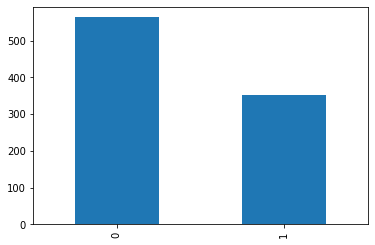

In [7]:
print(df_train['survived'].value_counts())
df_train['survived'].value_counts().plot.bar()

3    498
1    230
2    188
Name: pclass, dtype: int64


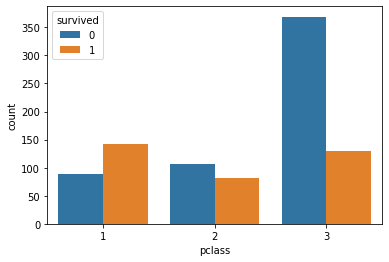

In [8]:
# survived 피처를 기준으로 그룹을 나누어 그룹별 pclass 피처의 분포를 살펴보자.
print(df_train['pclass'].value_counts())
ax = sns.countplot(x = 'pclass', hue = 'survived', data= df_train)

다음으로 age, sibsp와 같은 수치형 피처들에 대한 탐색을 진행한다. 다음의 코드는 이러한 피처들을 탐색할 수 있는 자동화 함수 vaild_feature()를 작성한 것이다. 함수가 실행하는 내용은 다음과 같다.

- 두 그룹 간의 분포를 비교하는 그래프를 출력한다.
- 두 그룹 각각의 표준편차를 출력한다.
- 두 그룹 간의 T-test 검정으 실시하여 출력한다.
- 두 그룹 각각에 Shapiro-wilk 검정을 실시하여 출력한다.

- 변수 탐색작업 자동화하기

In [9]:
from scipy import stats

# 두 집단의 피처를 비교해주며 탐색작업을 자동화하는 함수를 정의한다.
def valid_feature(df, col_name, distribution_check=True):
    
    # 두 집단 (survived=1, survive=0)의 분포 그래프를 출력한다.
    g = sns.FaceGrid(df, col='survived')
    g.map(plt.hist, col_name, bins=30)
    
    # 두 집단 (survived=1, survived=0)의 표준편차를 각각 출력한다.
    titanic_survived = df[df['survived']==1]
    titanic_survived_static = np.array(titanic_survived[col_name])
    print("data std is", '%.2f' %np.std(titanic_survived_static))
    titanic_n_survived = df[df['survived']==0]
    titanic_n_survived_static = np.array(titanic_n_survived[col_name])
    print("data std is", '%.2f'%np.std(titanic_n_survived_static))
    
    # T-test로 두 집단의 평균 차이를 검정한다.
    tTestResult = stats.ttest_ind(titanic_survived[col_came], titanic_n_survived[col_name])
    tTestResultDiffVar = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name], equal_var=False)
    print("The t-statistic and p-value assuming equal variances is %.3f and %.3f."% tTestResult)
    print("The t-statistic and p-value not assuming equal variances is %.3f and %.3f"% tTestResultDiffVar)
    
    if distribution_check:
        # Shapiro-Wilk 검정: 분포의 정규성 정도를 검증한다.
        print("The w-statistic and p-value in Survived %.3f and %.3f"% stats.shapiro(titanic_survived[col_name]))
        print("The w-statistic and p-value in Non-Survived %.3f and %.3f"% stats.shapiro(titanic_n_survived[col_name]))
    

아래의 실행 결과는 valid_features()를 실행한 것이다. 이를 통해 살펴본 피처는 age, sibsp 두 피처이다.

- 자동화 함수 실행하기

In [10]:
# 앞서 정의한 valid_features 함수를 실행한다. age 피처와 sibsp 피처를 탐색한다.
valid_features(df_train[df_train['age']>0], 'age', distribution_check=True)

valid_features(df_train, 'sibsp', distribution_check=False)

NameError: name 'valid_features' is not defined

In [11]:
# !pip3 install seaborn

In [12]:
# !pip3 install matplotlib

분석 결과, age 피처는 두 그룹 간의 평균 차이가 없기 때문에 생존자 분류에 미치는 영량력이 낮을것이라고 가정해볼 수 있다. 반면 sibsp 피처에서는 두 그룹 간의 평균 차이가 어느 정도 존재한다는 것을 알 수 있다.

#### Step 2 분류: 생존자 분류 모델 만들기

이제 분류 모델을 만들어보자. 예측 모델과 마찬가지로 분류 모델 역시 다양한 방법이 존재한다. 첫 번째로 시도해볼 방법은 **로지스틱 회귀 모델(Logistic regression)** 을 이용한 분류이다. 로지스틱 회귀 모델은 기존 회귀 분석의 예측값 Y를 0~1사이의 값으로 제한하여 0.5보다 크면 1, 0.5보다 작으면 0이라고 분류하는 방법이다. 로지스틱 회귀 모델은 일반적인 회귀 모델과 마찬가지로 계수 분석을 통한 피처의 영향력 해석이 용이하다는 장점이 있다. 로지스틱 모델을 사용하기 위해 회귀 분석을 수행할 때와 동일한 방법으로 데이터를 가공한다. 우선 결측값을 처리한다. 결측값이 존재하는 피처를 전처리하는 방법은 크데 두 가지이다.

- 결측이 존재하는 데이터들을 삭제하는 방법
- 평균값, 혹은 중앙값이나 최빈값 등의 임의의 수치로 채워 넣는 방법

첫번째는 처리가 쉽고 분석에서의 주관이 개일될 여지가 없다는 장점이 있다. 하지만 중요한 정보를 삭제하게 될 수도 있다. 두번째 방법은 데이터를 모두 분석에 활용할 수 있다는 장점이 있지만, 수치 왜곡의 가능성이 있다는 단점이 있다.

아래의 코드에서 두번째방법을 이용하여 age와 embark 피처의 결측값을 보정하였다. 그리고 원-핫인코딩 방법으로 범주형 변수를 변환한다. 현재 데이터셋은 train 데이터와 test 데이터로 분리되어있기 때문에 원-핫 인코딩을 적용하려면 하나의 데이터로 합쳐줄 필요가 있다. 그래서 두 데이터를 합친 whole_df에 원-핫 인코딩을 적용한 뒤, 다시 train과 test로 데이터를 분리한다.

- 분류 모델을 위해 전처리하기

In [13]:
# age 의 결측값을 평균값으로 대체하기

replace_mean = df_train[df_train['age']>0]['age'].mean()
df_train['age'] = df_train['age'].fillna(replace_mean)
df_test['age']= df_test['age'].fillna(replace_mean)

# embark: 2개의 결측값을 최빈값으로 대체한다.
embarked_mode = df_train['embarked'].value_counts().index[0]
df_train['embarked']= df_train['embarked'].fillna(embarked_mode)
df_test['embarked']= df_test['embarked'].fillna(embarked_mode)

# 원-핫 인코딩을 위한 통합 데이터 프레임(whole_df)을 생성한다.
whole_df = df_train.append(df_test)
train_idx_num = len(df_train)

# pandas 패키지를 이용한 원-핫 인코딩을 수행합니다.
whole_df_encoded = pd.get_dummies(whole_df)
df_train = whole_df_encoded[:train_idx_num]
df_test = whole_df_encoded[train_idx_num:]

df_train.head()

,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,1,0,0,0,1
1,2,1,4.000000,1,1,23.0000,1,0,0,0,1
2,2,1,30.000000,1,0,13.8583,1,0,1,0,0
3,3,0,30.231444,0,0,7.7250,0,1,0,1,0
4,3,1,22.000000,0,0,7.7250,1,0,0,1,0


이제 sklearn 모듈의 LogisticRegression 클래스로 모델을 학습하자

- 분류 모델링: 로지스틱 회귀 모델


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 데이터를 학습 데이터셋, 데이트 데이터셋으로 분리하자.

x_train, y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
x_test, y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values

# 로지스틱 회귀 모델을 학습한다.
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

# 학습한 모델의 테스트 데이터셋에 대한 예측 결과를 반환한다.
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


그렇다면 이 모델이 생존자를 얼마나 잘 분류하는지 어떻게 평가할까? 일반적으로 분류 모델의 평가 기준은 Confusion Matrix라는 것을 활용 한다. 다음의 코드는 정확도, 정밀도, 특이도, F1-score 네 가지 지표로 모델을 평가한 것이다. predict()함수로 분류한 예측값들을 sklearn.metrics모듈의 accuracy_score, precision_score, recall_score, f1_score 함수에 적용하면 다음과 같은 출력 결과를 얻을 수 있다.



- 분류 모델 평가하기

In [15]:
# 테스트 데이터셋에 대한 정확도, 정밀도, 특이도, f1 평가 지표를 각각 출력한다.

print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recll: %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.80
Precision : 0.756
Recll: 0.673
F1 : 0.712


그리고 다음의 코드는 Confusion Matrix를 직접 출력한 것이다.

In [16]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix를 출력한다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[214  32]
 [ 48  99]]


마지막으로 AUC를 출력해보자. AUC 출력은 분류 결과인 0혹은 1의 y값(y_pred)을 사용하는 것이 아니라, 분류 직전의 확률값(y_pred_probability)인 0~1 사이의 값을 사용해야 한다. 아래 코드는 AUC를 출력함과 동시에 ROC Curve를 그래프로 나타낸 것이다. 이 모델의 AUC는 약 0.837로, 생존자를 잘 분류해내는 모델이라고 평가할 수 있다.

AUC : 0.838


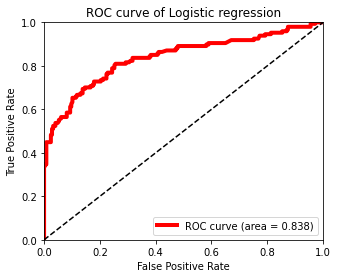

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score

# AUC (Area Under the Curve)를 계산하여 출력합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve를 그래프로 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

아래 코드와 실행 결과는 로지스틱 회귀 모델과 더불어 분류 분석의 가장 대표적인 방법인 의사결정나무(Decision Tree)모델을 적용한 결과 이다. 하지만 로지스틱 회귀 모델에 비해 모든 평가 지표가 낮은 것을 확인할 수 있다.

- 의사결정 나무

accuracy: 0.77
Precision: 0.716
Recall: 0.653
F1: 0.683
AUC: 0.838


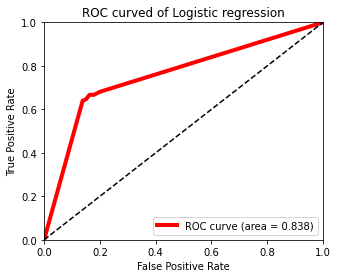

In [18]:
from sklearn.tree import DecisionTreeClassifier

# 의사결정 나무를 학습하고, 학습한 모델로 테스트 데이터셋에 대한 예측값을 반환한다.
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
y_pred_probability = dtc.predict_proba(x_test)[:,1]

# 학습한 모델의 성능을 계산하여 출력한다.

print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision: %.3f" % precision_score(y_test, y_pred))
print("Recall: %.3f" % recall_score(y_test, y_pred))
print("F1: %.3f" % f1_score(y_test, y_pred))

# 학습한 모델의 AUC를 계산하여 출력한다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
print("AUC: %.3f" % roc_auc)

# ROC curve를 그래프로 출력한다.
plt.rcParams['figure.figsize'] = [5,4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)'% roc_auc, color='red', linewidth=4.0)

plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curved of Logistic regression')
plt.legend(loc = "lower right")


#### Step 3 모델 개선: 피처 엔지니어링 첫걸음

분류 모델의 성능을 더욱 끌어올리기 위해서는 어떻게 해야 할까? 가장 먼저 생각해볼 수 있는 것은 '더 좋은 분류 기법'을 사용하는 것이다. 혹은 '더 많은 데이터'를 사용하는 것도 좋은 방법일 것이다. 하지만 이 방법들은 쉽게 적용할 수 있는 것이 아니다. 이럴 때 분석가가 사용할 수 있는 무기는 바로 피처 엔지니어링(feature engineering)이다. 피처 엔지니어링이란 모델에 사용할 피처를 가공하는 분석 작업을 의미한다. 이를 수행하기 우해 분석 과정을 처음부터 다시 시작하겠다. 먼저 다음의 코드와 같이 age, embark 피처의 결측값을 처리해준 뒤, whole_df라는 통합 데이터 프레임을 생성하자.

- 분류 모델을 위해 전처리하기

In [19]:
# 데이터를 다시 불러온다.
df_train = pd.read_csv("./data/titanic_train.csv")
df_test = pd.read_csv("./data/titanic_test.csv")
df_train =  df_train.drop(['ticket', 'body', 'home.dest'], axis=1 )
df_test = df_test.drop(['ticket', 'body', 'home.dest'], axis=1)

# age의 결측값을 평균값으로 대체한다.
replace_mean = df_train[df_train['age'] > 0 ]['age'].mean()
df_train['age'] = df_train['age'].fillna(replace_mean)
df_test['age'] = df_test['age'].fillna(replace_mean)

# embark: 2개의 결측값을 최빈값으로 대체한다.
embarked_mode = df_train['embarked'].value_counts().index[0]
df_train['embarked'] = df_train['embarked'].fillna(embarked_mode)
df_test['embarked'] = df_test['embarked'].fillna(embarked_mode)

# 원-핫 인코딩을 위한 통합 데이터 프레임 (whole_df)을 생성하자.
whole_df = df_train.append(df_test)
train_idx_num = len(df_train)

이번에는 cabin 피처와 name 피처를 가공하여 분석에 포함하자. cabin 피처는 선실의 정보를 나타내는 데이터로, 선실을 대표하는 알파벳이 반드시 첫 글자에 등장한다는 패턴을 가지고 있다.

- cabin 피처 활용하기

In [20]:
print(whole_df['cabin'].value_counts()[:10])

C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
D                  4
F33                4
C78                4
F4                 4
F2                 4
C22 C26            4
B96 B98            4
Name: cabin, dtype: int64


이 피처의 결측 데이터는 알파벳이 없다는 의미의 'X'알파벳으로 채워준다. 그리고 데이터의 수가 매우 적은 G와 T선실 역시 'X'로 대체한다. 마지막으로 cabin 피처에서 첫 번째 알파벳을 추출하기 위해 whole_df['cabin'].apply(lambda x:x[0]) 코드를 실행하자.

- cabin 피처 활용하기


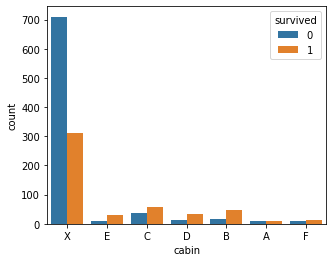

In [21]:
# 결측 데이터의 경우는 'X'로 대체한다.

whole_df['cabin'] = whole_df['cabin'].fillna('X')

# cabin 피처의 첫 번째 알파벳을 추출한다.

whole_df['cabin'] = whole_df['cabin'].apply(lambda x:x[0])

# 추출한 알파벳 중, G와 T는 수가 너무 작기 때문에 마찬가지로 'X'로 대체한다.

whole_df['cabin'] = whole_df['cabin'].replace({"G":"X", "T":"X"})

ax = sns.countplot(x='cabin', hue='survived', data=whole_df)
plt.show()

전처리가 완료된 cabin 피처의 생존자/비생존자 그룹 간 분포는 위와 같다. 이를 살펴본 결과, 두 그룹 간의 유의미한 차이가 있는 것으로 보인다.따라서 우리는 이 피처를 분류 모델에 사용해볼 수 있다.

다음으로 name 피처를 살펴보자. 얼핏 봐서는 이름이라는 데이터를 어떻게 피처로 사용할 수 있을지 난감하다. 하지만 데이터를 자세히 살펴보면 이 피처 또한 데이터 간의 공통점이 있음을 발견할 수 있다. 바로 이름의 구성 중간에 들어가는 **호칭** 정보이다.

데이터셋의 이름 중 Bradley, Miss.Bridget Delia 라는 이름을 예로 들어보자. 이 이름은 Bradley라는 성, Miss라는 호칭, Bridget Delia라는 이름으로 구성되어 있다. 그리고 모든 이름은 이러한 형태로 구성되어 있다. 당시 시대는 사회적 계급이 엄연히 존재하였기 때문에 호칭 정본느 매우 중요한 데이터로 활용될 수 있다. 호칭을 추출한 결과는 다음과 같다.

- name 피처 활용하기


In [22]:
# 이름에서 호칭을 추출한다.
name_grade = whole_df['name'].apply(lambda x: x.split(",",1)[1].split(".")[0])
name_grade = name_grade.unique().tolist()
print(name_grade)

[' Miss', ' Mr', ' Master', ' Mrs', ' Dr', ' Mlle', ' Col', ' Rev', ' Ms', ' Mme', ' Sir', ' the Countess', ' Dona', ' Jonkheer', ' Lady', ' Major', ' Don', ' Capt']


앞선 단계에서 추출한 호칭을 여섯 가지의 사회적 지위로 정의할 수 있다. 아래 코드의 give_grade()함수로 whole_df의 name피처를 A~F의 범주형 데이터로 변환하는 작업을 수행하자.

- name 피처 활용하기

In [23]:
# 호칭에 따라 사회적 지위(1910년대 기준)를 정의합니다.
grade_dict = {'A': ['Rev', 'Col', 'Major', 'Dr', 'Capt', 'Sir'], # 명예직을 나타냅니다.
              'B': ['Ms', 'Mme', 'Mrs', 'Dona'], # 여성을 나타냅니다.
              'C': ['Jonkheer', 'the Countess'], # 귀족이나 작위를 나타냅니다.
              'D': ['Mr', 'Don'], # 남성을 나타냅니다.
              'E': ['Master'], # 젊은남성을 나타냅니다.
              'F': ['Miss', 'Mlle', 'Lady']} # 젊은 여성을 나타냅니다.

# 정의한 호칭의 기준에 따라, A~F의 문자로 name 피처를 다시 정의하는 함수입니다.
def give_grade(x):
    grade = x.split(", ", 1)[1].split(".")[0]
    for key, value in grade_dict.items():
        for title in value:
            if grade == title:
                return key
    return 'G'
    
# 위의 함수를 적용하여 name 피처를 새롭게 정의합니다.
whole_df['name'] = whole_df['name'].apply(lambda x: give_grade(x))
print(whole_df['name'].value_counts())

D    758
F    263
B    201
E     61
A     24
C      2
Name: name, dtype: int64


이제 모델을 학습하기 위한 마지막 전처리 단계로 모든 범주형 피처들에 원-핫 인코딩을 적용하자.

- 원-핫 인코딩

In [24]:
# 판다스 패키지를 이용한 원-핫 인코딩을 수행하자

whole_df_encoded = pd.get_dummies(whole_df)
df_train = whole_df_encoded[:train_idx_num]
df_test = whole_df_encoded[train_idx_num:]
df_train.head()

,pclass,survived,age,sibsp,parch,fare,name_A,name_B,name_C,name_D,...,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_X,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,2,1,4.000000,1,1,23.0000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,2,1,30.000000,1,0,13.8583,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,3,0,30.231444,0,0,7.7250,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
4,3,1,22.000000,0,0,7.7250,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


'cabin','name'을 대상으로 피처 엔지니어링을 적용한 뒤, 다시 학습한 모델의 평과 결과는 아래와 같습니다. accuracy와 precision은 기존 모델에 비해 소폭 감소한 반면, F1 score와 AUC는 대폭 상승했다. 이를 통해 분류 모델의 성능이 많이 향상되었다는 것을 알 수 있다.

- 피처 엔지니어링이 완료된 데이터셋 학습

accuracy: 0.79
Precision : 0.736
Recall : 0.701
F1 : 0.718
AUC : 0.853


/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


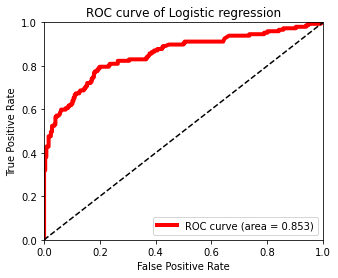

In [25]:
# 데이터를 학습 데이터셋, 테스트 데이터셋으로 분리합니다.
x_train, y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
x_test, y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values

# 로지스틱 회귀 모델을 학습합니다.
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

# 학습한 모델의 테스트 데이터셋에 대한 예측 결과를 반환합니다.
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 테스트 데이터셋에 대한 accuracy, precision, recall, f1 평가 지표를 각각 출력합니다.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred)) # AUC (Area Under the Curve) & ROC curve

# AUC (Area Under the Curve)를 계산하여 출력합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve를 그래프로 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

다음의 코드는 분류 모델의 피처 영향력을 그래프로 살펴본 것이다. 우리는 이를 통해 피처 엔지니어링으로 생성된 'name', 'cabin'피처의 영향력이 가장 크다는 것을 알 수 있다.

- 피처 영향력 살펴보기

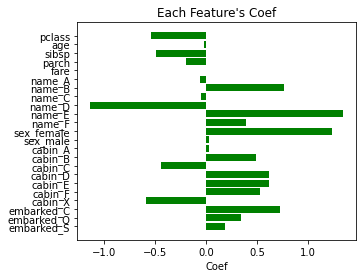

In [26]:
# 예측 대상인 survived 피처를 제외한 모든 피처를 리스트로 반환한다. (그래프의 y축)

cols = df_train.columns.tolist()
cols.remove('survived')
y_pos = np.arange(len(cols))

# 각 피처별 회귀 분석 계수를 그래프의 x축으로 하여 피처 영향력 그래프를 출력하자.

plt.rcParams['figure.figsize'] = [5,4]
fig, ax = plt.subplots()
ax.barh(y_pos, lr.coef_[0], align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(cols)
ax.invert_yaxis()
ax.set_xlabel('Coef')
ax.set_title("Each Feature's Coef")

plt.show()

#### Step 4 평가: 모델 검증하기

마지막 단계는 완성된 분류 모델을 검증하는 단계이다. 이를 위해 **모델의 과적합 여부**를 검증해야 한다. 우리가 알아볼 과적합 검증 방법은 두 가지이다. 첫 번째는 K-fold 교차 검증, 그리고 두 번째는 학습 곡선을 살펴보는 방법이다. K-fold 교차 검증을 수행하기 위한 코드는 아래와 같다. 우선 sklearn.model_selection의 KFold 클래스로 cv라는 객체를 반환합니다. 그리고 이 객체의 split함수를 for 반복문과 같이 사용하는데, 반복문에서는 전체 데이터를 k개로 분리하여 학습과 평가를 반복한다.

- K-flod 교차 검증 수행하기

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#lo

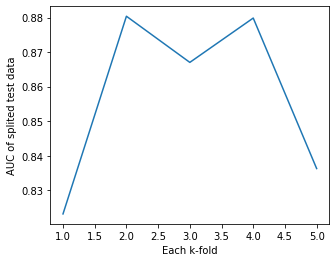

In [27]:
from sklearn.model_selection import KFold

# K-fold 교차 검증의 k를 5로 설정한다.
k = 5
cv = KFold(k, shuffle=True, random_state=0)
auc_history = []

# K-fold를 5번의 분할 학습으로 반복한다.
for i, (train_data_row, test_data_row) in enumerate(cv.split(whole_df_encoded)):
    
    # 5개로 분할된 fold 중 4개를 학습 데이터셋, 1개를 테스트 데이터셋으로 지정한다. 매 반복시 마다 테스트 데이터셋은 변경된다.
    
    df_train = whole_df_encoded.iloc[train_data_row]
    df_test = whole_df_encoded.iloc[test_data_row]

# survived 피처를 y, 나머지 피처들을 x 데이터로 지정한다.
    splited_x_train, splited_y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
    splited_x_test,  splited_y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values

# 주어진 데이터로 로지스틱 회귀 모델을 학습한다.
    lr = LogisticRegression(random_state=0)
    lr.fit(splited_x_train, splited_y_train)
    y_pred = lr.predict(splited_x_test)
    y_pred_probability = lr.predict_proba(splited_x_test)[:,1]

# 테스트 데이터셋의 AUC 를 계산하여 auc_history에 저장한다.
    false_positive_rate, true_positive_rate, thresholds= roc_curve(splited_y_test, y_pred_probability)
    roc_auc = roc_auc_score(splited_y_test, y_pred_probability)
    auc_history.append(roc_auc)

# auc_history에 저장된 다섯 번의 학습 결과(AUC)를 그래프로 출력한다.

plt.xlabel("Each k-fold")
plt.ylabel("AUC of splited test data")
plt.plot(range(1, k+1), auc_history) # baseline

아래의 실행 결과는 교차 검증의 k번째 실행마다 AUC를 리스트에 저장하고, 이를 그래프로 나타낸 것이다. 그래프를 살펴본 결과, AUC가 큰 폭으로 변화하고 있는 것을 볼 수 있다. 따라서 이 모델은 다소 불안정한 모델이라고 할 수 있다. 다만 이러한 결과는 데이터의 개수가 적기 때문에 발생하는 현상이다. 게다가 모든 실행에서 공통적으로 Test AUC가 0.8 이상의 수치를 기록했기 때문에 이 분류 모델은 '과적합이 발생했지만 대체로 높은 정확도를 가지는 모델'이라고 할 수 있다.

In [28]:
#!pip3 install scikit-plot

학습 데이터와 테스트 데이터의 점수가 벌어지는 과적합 상황은 학습 곡선을 관찰함으로써 더 쉽게 관찰할 수 있다. 다음의 그래프는 학습 데이터 샘플의 개수가 증가함에 따라 학습과 테스트 두 점수가 어떻게 변화하는지를 관찰한 그래프이다. 이를 통해 데이터가 300개가 이상인 경우에는 과적합의 위험이 낮아진다는 것을 알 수 있다.

- 학습 곡선 분석하기

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#lo

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#lo

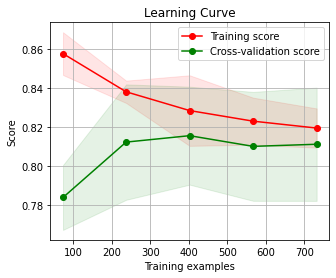

In [29]:
import scikitplot as skplt
skplt.estimators.plot_learning_curve(lr, x_train, y_train)
plt.show()